# Identificación por mínimos cuadrados recursivos

In [2]:
import control as ctrl
import numpy as np
from matplotlib import pyplot as plt
import scipy as sc

## Influencia de la excitación en la estimación

Se tiene el siguiente sistema a identificar

$$ y_k +a y_{k-1} = b u_{k-1} + e_{k} $$

Que puede factorizarse de la siguiente manera 

$$ y_k = -a y_{k-1} + b u_{k-1} + e_{k} $$
$$ y_k = \varphi_{k}^\top \theta  + e_{k} $$
con
$$ \varphi_k = [-y_{k-1}, u_{k-1}]$$
$$ \theta = [a , b ]$$


In [2]:
# Parámetros verdaderos
a, b, c = -0.8, 0.5, 0.0
def obtener_datos(u,e,A=a,B=b,C=0):
    N = len(u)
    y = np.zeros_like(u)
    for k in range(1, N):  
        y[k] = -A*y[k-1] + B*u[k-1] + e[k] + C*e[k-1] # c=0

    return y

In [79]:
# Estimador por mínimos cuadrados recursivo para un modelo ARX
def estimador_RLS(u,y,na=1, nb=1,lambda_=1,theta_ini=None, theta_real=None,plot=True):
    N = len(u)
    if np.all(theta_ini)==None:
        theta_hat = np.zeros(na+nb)       # estimación inicial [a_hat, b_hat]
    else:
        theta_hat = theta_ini
    P = 100 * np.eye(na+nb)          # matriz de incertidumbre grande
    err = np.zeros_like(y)
    y_hat = np.zeros_like(y)

    theta_hist = []    
    k_range = range(na+1, N)
    for k in k_range:
        phi = np.concatenate((-y[k-1:k-na-1:-1], u[k-1:k-nb-1:-1]))   # vector de regresores
        y_hat[k] = phi @ theta_hat
        err[k] = y[k] - y_hat[k]

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        theta_hist.append(theta_hat.copy())

    theta_hist = np.array(theta_hist)

    # Validación
    N_lag = 50
    ree = np.correlate(err,err,'full')    
    rey = np.correlate(err,y_hat,'full')
    ryy = np.correlate(y_hat,y_hat,'full')
    RN = ree/(rey*ryy+0.001)**0.5    
    lags = np.arange(-len(err)+1, len(err))
    center = len(ree) // 2
    ree = ree[center-N_lag:center+N_lag+1]
    RN = RN[center-N_lag:center+N_lag+1]
    lags_plot = lags[center-N_lag:center+N_lag+1]
    ree_max_val = 2.17/np.sqrt(N)*ree[N_lag]
    RN_max_val = 2.17/np.sqrt(N)*RN[N_lag]
    print(f"ree(0)={ree[N_lag]}  ree(1)={ree[N_lag+1]}   Maximo permitido: {ree_max_val}")

    if plot:
        plt.subplot(211)        
        plt.step(k_range,err[k_range],where='post')
        #plt.xlabel('Tiempo [s]')
        plt.ylabel('Error de predicción')
        plt.subplot(212)
        for idx_na in range(0,na):
            plt.step(k_range,theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
        for idx_nb in range(0,nb):
            plt.step(k_range,theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb+1}}}$",where='post')
        if theta_real!=None:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
            for idx_na in range(na):
                color = colors[idx_na % len(colors)]
                plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na}$")
            for idx_nb in range(nb):
                color = colors[(idx_nb+na) % len(colors)]
                plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            
        plt.legend()
        plt.xlabel('k')
        plt.ylabel('$\\theta$')
        plt.show()

        # Observemos la correlación del error de predicción

        #Pee = np.fft.fft(ree)
        #w = np.fft.fftfreq(N, 1)*2*np.pi 
        plt.figure()
        #plt.subplot(211)
        plt.plot(lags_plot,ree)
        plt.ylabel('$r_{{ee}}$')    
        plt.axhline(ree_max_val, linestyle='--', color='r', label=f"$ree_{{max}}$") 
        plt.title('Validación del modelo')           
        #plt.subplot(212)
        #plt.plot(lags_plot,RN)
        #plt.ylabel('$R_{{e\\hat{{y}}}}$')
        #plt.axhline(RN_max_val, linestyle='--', color='r', label=f"$R_{{N,max}}$") 
        plt.xlabel('lag')
        plt.show()

    return theta_hist,P,err,ree


### Ensayo 1: entrada pulso

ree(0)=0.4100012398156698  ree(1)=0.2003738356456804   Maximo permitido: 0.08897026904000035


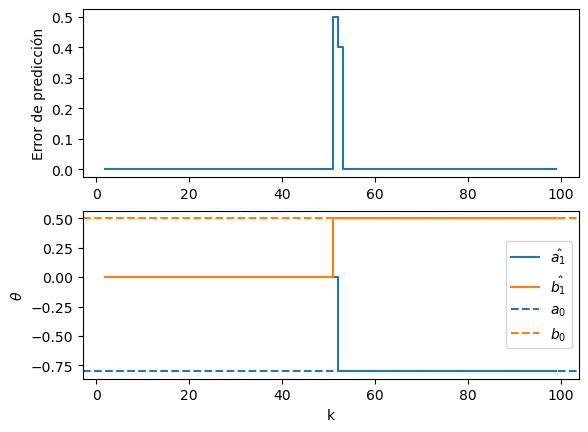

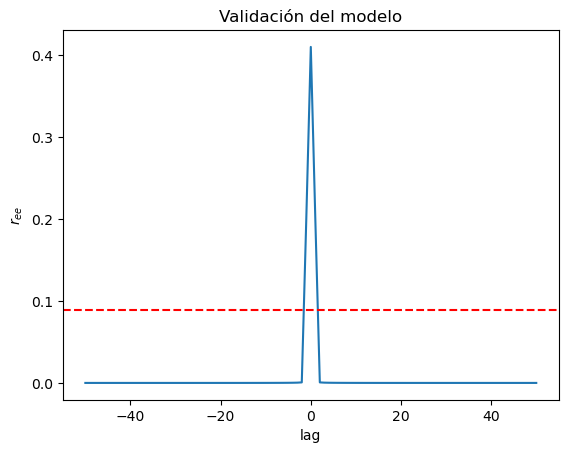

Theta estimado = [-0.79923743  0.49961557]


In [80]:
N = 100
u = np.zeros(N)
# Ver qué pasa si modifico la amplitud!
u[50] = 1
e = np.zeros_like(u)
y = obtener_datos(u,e)

theta_hat,_,_,_ = estimador_RLS(u,y,lambda_=0.95,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat[-1,:]}")

### Ensayo 2: entrada pulso + ruido (modelo ARX)

ree(0)=486.66421488127753  ree(1)=22.11919167987639   Maximo permitido: 23.6142495871969


/tmp/ipykernel_31016/1512210763.py:32: RuntimeWarning: invalid value encountered in sqrt
  RN = ree/(rey*ryy+0.001)**0.5


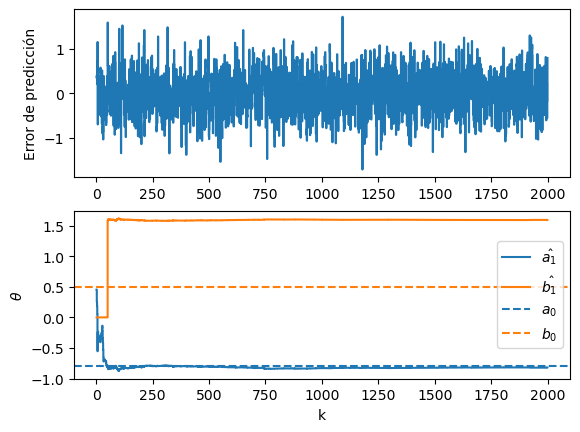

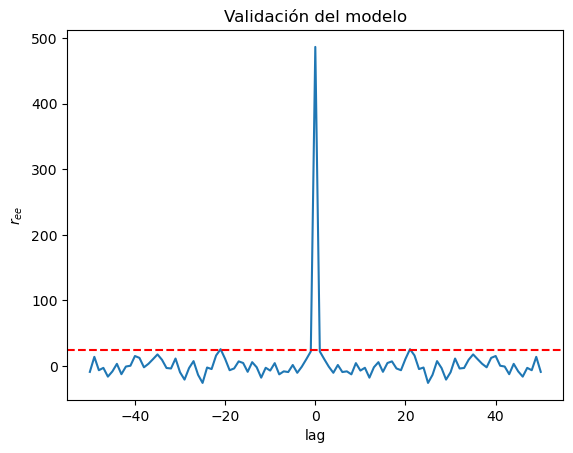

Theta estimado = [-0.82116267  1.59237714]
Desvío de la estimación = [0.012976   0.49755284]


In [81]:
N = 2000
u = np.zeros(N)
# Ver qué pasa si modifico la amplitud!
u[50] = 1
sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e)

theta_hat,P,_,_ = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

# ¿Cómo es que puedo identificar bien a, pero b no?
# Ver qué pasa si u es 0

### Ensayo 3: entrada tren de pulsos + ruido (modelo ARX)

/tmp/ipykernel_31016/1512210763.py:32: RuntimeWarning: invalid value encountered in sqrt
  RN = ree/(rey*ryy+0.001)**0.5


ree(0)=648.5631285078863  ree(1)=3.3653989966268454   Maximo permitido: 28.147639777242265


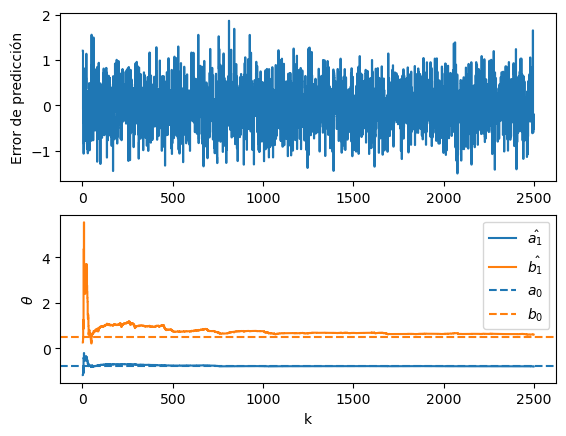

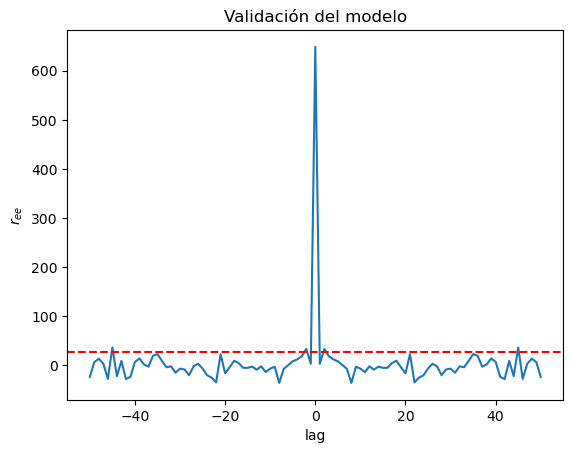

Theta estimado = [-0.80384756  0.60368446]
Desvío de la estimación = [0.01170171 0.07788635]


In [82]:
from scipy import signal

N = 2500
t = np.arange(N)
u = 0.1 * (signal.square(2*np.pi * t / 200, duty=0.5) + 1) 

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e)

theta_hat,P,_,_ = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

### Ensayo 4: entrada PRBS + ruido (ARX)

/tmp/ipykernel_31016/1512210763.py:32: RuntimeWarning: invalid value encountered in sqrt
  RN = ree/(rey*ryy+0.001)**0.5


ree(0)=258.85674070668995  ree(1)=0.21626446744885142   Maximo permitido: 17.763118476560585


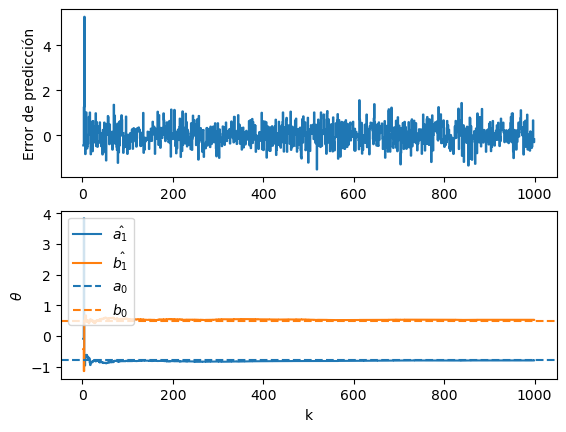

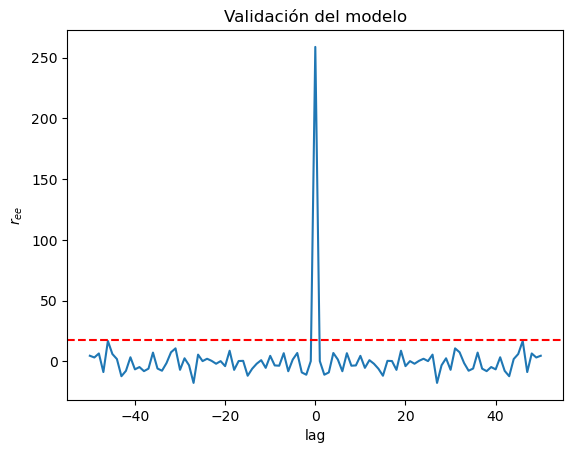

Theta estimado = [-0.8017967  0.5246084]
Desvío de la estimación = [0.0134004  0.01582722]


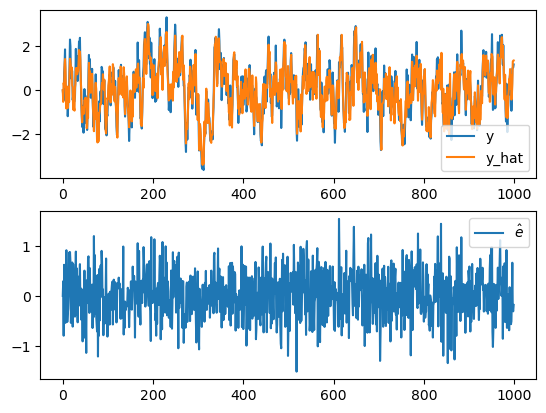

In [83]:
N = 1000
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e)

theta_hat,P,_,_ = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

# Calculo el error de predicción
y_hat = np.zeros_like(y)
for k in range(1,N):
    y_hat[k] = -theta_hat[-1,0]*y[k-1] + theta_hat[-1,1]*u[k-1]
e_pred = y - y_hat

# Valido con viendo el error de predicción
plt.figure()
plt.subplot(211)
plt.plot(y, label='y')
plt.plot(y_hat, label='y_hat')
plt.legend()
plt.subplot(212)
plt.plot(e_pred, label='$\\hat{e}$')
plt.legend()
plt.show()



## Influencia de la estructura del modelo

entrada PRBS + ruido coloreado

Observar que al usar RLS pensando que el modelo es ARX y el ruido es blanco, se comete un error en la estimación.
Si miramos solamente el desvío del estimador, pensamos que alcanzó una buena estimación. Claramente esto no es correcto porque difiere mucho del valor verdadero.

Un indicio de este problema lo muestra la gráfica de correlación del error de estimación. Se ve cierto grado de correlación lo que implica que los datos todavía tienen más información para extraer

/tmp/ipykernel_31016/1512210763.py:32: RuntimeWarning: invalid value encountered in sqrt
  RN = ree/(rey*ryy+0.001)**0.5


ree(0)=787.286600260967  ree(1)=-237.52034625513963   Maximo permitido: 34.16823845132597


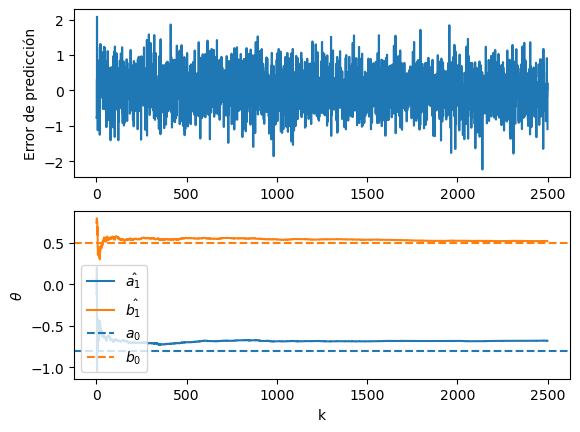

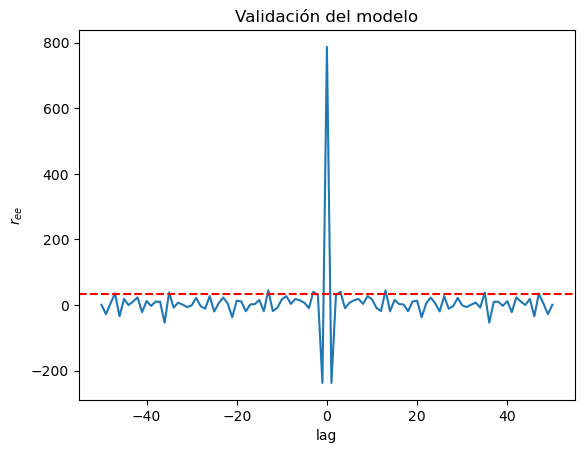

Theta estimado = [-0.67935342  0.52288261]
Desvío de la estimación = [0.00958108 0.01000401]


In [85]:
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
y = obtener_datos(u,e,C=-0.5)

theta_hat,P,_,_ = estimador_RLS(u,y,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

### Modelos estocásticos

Para solucionar el problema visto en el ensayo anterior se puede incorporar el modelo del ruido a la identificación.

Consideremos el modelo a identificar:
$$A(q) y_k = B(q) u_k + C(q) e_k$$

con $\{e_k\}$ ruido blanco.

No podemos transformar este modelo a uno de regresión, porque no conocemos $e_k$, entonces no tendríamos forma de incorporarlo al regresor $\varphi_k$.

Si embargo nos podemos valer del error de predicción $\epsilon_k = y_k - \varphi_{k-1} \hat{\theta}_{k-1}$ para aproximar $e_k$

Resulta:
$$\varphi_k =[-y_{k-1}, \dots,-y_{k-n_a}, u_{k-1},\dots,u_{k-n_b},\epsilon_{k-1},\dots,\epsilon_{k-n_c} ] $$
$$\theta = [a_1, \dots, a_{n_a}, b_1, \dots, b_{n_b},c_1,\dots, c_{n_c}]$$

In [86]:
# Estimador por mínimos cuadrados extendido para un modelo ARX con ruido coloreado
def estimador_ELS(u,y,na=1, nb=1, nc=1, lambda_=1,theta_real=None,plot=True):
    N = len(u)
    theta_hat = np.zeros(na+nb+nc)       # estimación inicial [a_hat, b_hat]
    P = 100 * np.eye(na+nb+nc)          # matriz de covarianza grande
    err = np.zeros_like(y)

    theta_hist = []    
    k_range = range(na+1, N)
    for k in k_range:
        phi = np.concatenate((-y[k-1:k-na-1:-1], u[k-1:k-nb-1:-1], err[k-1:k-nc-1:-1]))   # vector de regresores
        y_hat = phi @ theta_hat
        err[k] = y[k] - y_hat

        K = P @ phi / (lambda_ + phi.T @ P @ phi)
        theta_hat = theta_hat + K * err[k]
        P = (P - np.outer(K, phi) @ P) / lambda_

        theta_hist.append(theta_hat.copy())

    theta_hist = np.array(theta_hist)

    if plot:
        plt.subplot(211)        
        plt.step(k_range,err[k_range],where='post')
        #plt.xlabel('Tiempo [s]')
        plt.ylabel('Error de predicción')
        plt.subplot(212)
        for idx_na in range(0,na):
            plt.step(k_range,theta_hist[:,idx_na], label=f"$\\hat{{a_{idx_na+1}}}$",where='post')
        for idx_nb in range(0,nb):
            plt.step(k_range,theta_hist[:,na+idx_nb], label=f"$\\hat{{b_{idx_nb+1}}}$",where='post')
        for idx_nc in range(0,nc):
            plt.step(k_range,theta_hist[:,na+nb+idx_nc], label=f"$\\hat{{c_{idx_nc+1}}}$",where='post')
        if theta_real!=None:
            colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
            for idx_na in range(na):
                color = colors[idx_na % len(colors)]
                plt.axhline(theta_real[idx_na], linestyle='--', color=color, label=f"$a_{idx_na}$")
            for idx_nb in range(nb):
                color = colors[(idx_nb+na) % len(colors)]
                plt.axhline(theta_real[idx_nb+na], linestyle='--', color=color, label=f"$b_{idx_nb}$")            
            for idx_nc in range(nc):
                color = colors[(idx_nc+na+nb) % len(colors)]
                plt.axhline(theta_real[idx_nc+na+nb], linestyle='--', color=color, label=f"$c_{idx_nc}$")            
        plt.legend()
        plt.xlabel('k')
        plt.ylabel('$\\theta$')
        plt.show()

        # Observemos la correlación del error de predicción
        N_lag = 50
        ree = np.correlate(err,err,'full')
        lags = np.arange(-len(err)+1, len(err))
        center = len(ree) // 2
        ree = ree[center-N_lag:center+N_lag+1]
        lags_plot = lags[center-N_lag:center+N_lag+1]

        #Pee = np.fft.fft(ree)
        #w = np.fft.fftfreq(N, 1)*2*np.pi 
        plt.figure()
        #plt.subplot(211)
        plt.plot(lags_plot,ree)
        plt.ylabel('$r_{{ee}}$')
        plt.xlabel('lag')
        #plt.subplot(212)
        #plt.plot(w,Pee)
        #plt.ylabel('$S_{{ee}}$')
        #plt.xlabel('$\\omega_r [rad]$')
    return theta_hist,P


### Repetimos ensayo anterior pero usando ELS

En este caso vemos que el residuo no queda autocorrelacionado

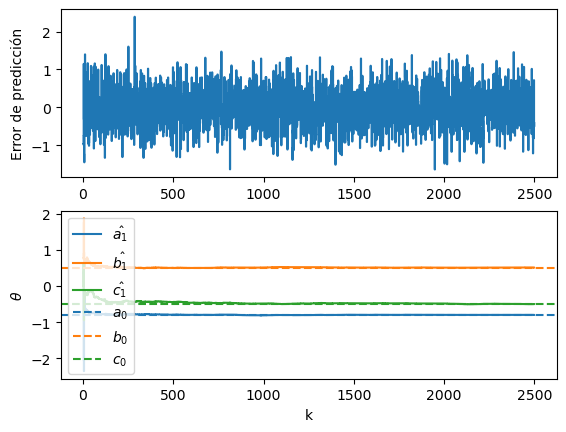

Theta estimado = [-0.79721753  0.51586993 -0.49855124]
Desvío de la estimación = [0.01087995 0.0100071  0.02234542]


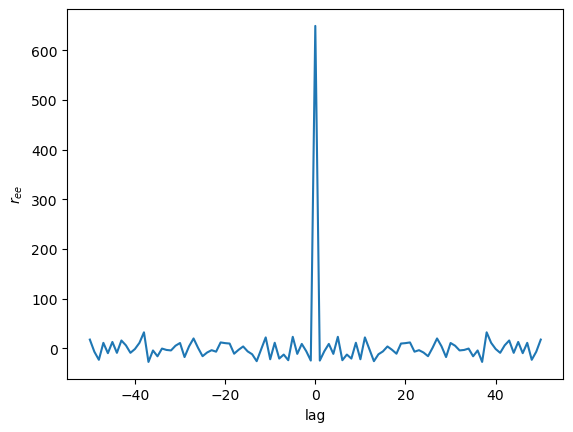

In [87]:
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)
c = -0.5
y = obtener_datos(u,e,C=c)

theta_hat,P = estimador_ELS(u,y,lambda_=1,na=1,nb=1,nc=1, theta_real=[a,b,c])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

### Repetimos ensayo anterior pero usando sippy


Modelo identificado (discreto):
<TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']
dt = 1.0

    0.4998
  ----------
  z - 0.8007
Polinomios Estimados:
A(z): [1.0, -0.8007438738925796]    Real  [1, -0.8]
B(z): [0.4997881397459221]   Real  [0.5]
C(z): [1.0, -0.48026104556098037]   Real  [1 -0.5]


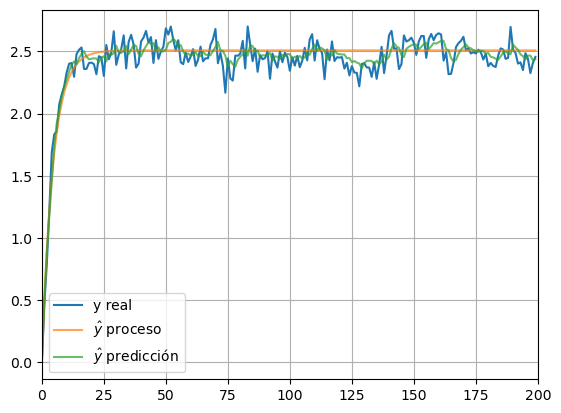

In [88]:
import sippy_unipi as sippy 
from sippy_unipi import functionset as fset
from sippy_unipi import functionsetSIM as fsetSIM

# ====================================
# 1. Parámetros y datos simulados
# ====================================
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))  # entrada ±1

sigma_e = 0.5
e = sigma_e*np.random.randn(N)

# Parámetros reales (ejemplo ARMAX)
c = -0.5  # coef. ruido coloreado
y = obtener_datos(u,e,C=c)

# ====================================
# 2. Identificación con sippy
# ====================================
# Ordenes: AR=1, X=1 (entrada), MA=1
sys_id = sippy.system_identification(y, u,
                                     'ARMAX', # probar con 'ARX', 'ARMA' ... Pero hay que ajustar los oredenes
                                     na_ord=1, nb_ord=1, nc_ord=1,
                                     delays=1)

# Modelo identificado
Gz = sys_id.G
print("Modelo identificado (discreto):")
print(Gz)

# Parámetros AR, X, MA
print("Polinomios Estimados:")
print(f"A(z): {sys_id.DENOMINATOR[0][0]}    Real  [1, {a}]")
print(f"B(z): {sys_id.NUMERATOR[0][0]}   Real  [{b}]")
print(f"C(z): {sys_id.NUMERATOR_H[0][0]}   Real  [1 {c}]")

# ====================================
# 3. Validación
# ====================================
N = 200
t = np.arange(N)
u = np.ones(N)

sigma_e = 0.1
e = sigma_e*np.random.randn(N)

# Parámetros reales (ejemplo ARMAX)
y = obtener_datos(u,e,C=c)
y_hat_prediction = fset.validation(sys_id,u,y,t, k = 1)

# La simulación se realiza sobre el sistema en espacio de estados
Gss = ctrl.tf2ss(sys_id.G)
sys_response = fset.forced_response(Gss,T=t,U=u)
# Otra forma de simular la respuesta del sistema
#x,y_hat_process = fsetSIM.SS_lsim_process_form(Gss.A, Gss.B, Gss.C, Gss.D, u.reshape((1,N)), np.array([[0]]))

plt.plot(y, label="y real")
#plt.plot(y_hat_process.reshape(-1), label="$\hat{{y}}$ proceso", alpha=0.7)
plt.plot(sys_response.y.reshape(-1), label="$\hat{{y}}$ proceso", alpha=0.7)
plt.plot(y_hat_prediction.reshape(-1),label="$\hat{{y}}$ predicción",alpha=0.7)
plt.legend()
plt.grid()
plt.xlim(0,200)
plt.show()



## Estimación a lazo cerrado

La identificabilidad de un sistema se puede perder cuando las señales de entrada son combinaciones lineales de la salida.

Se proponen las siguientes leyes de control:
- $u_k=-0.2y_{k}$
- $u_k=-0.32y_{k-1}$

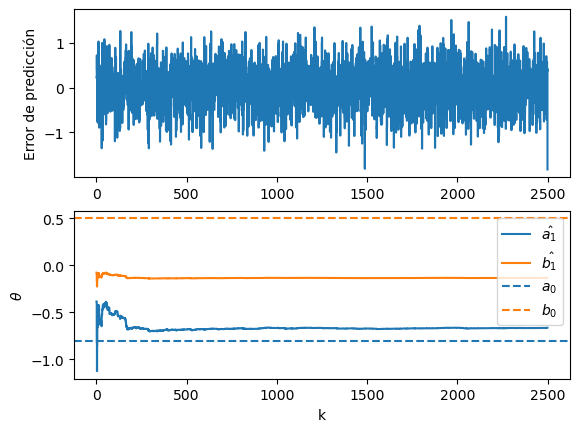

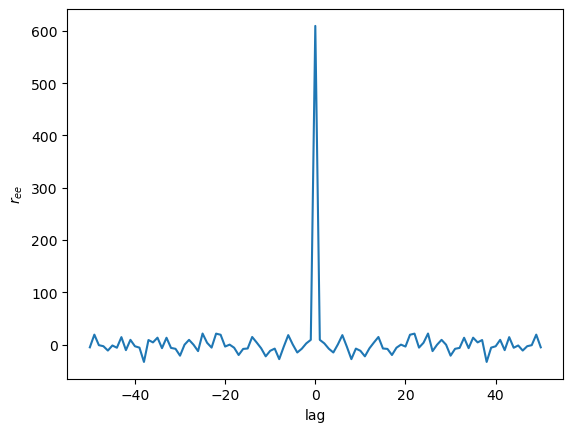

Theta estimado = [-0.66349128 -0.13269826]
Desvío de la estimación = [0.9806825  4.90290419]


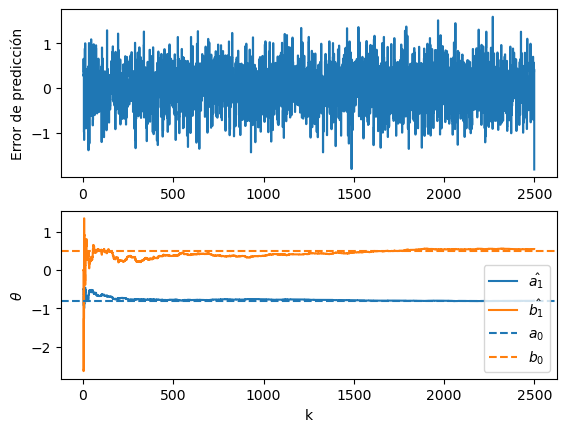

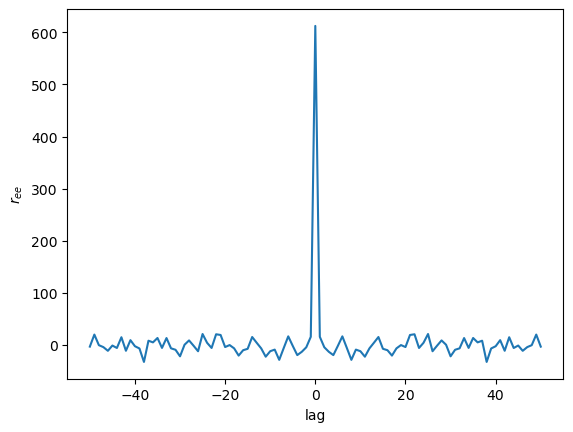

Theta estimado = [-0.80369947  0.54856625]
Desvío de la estimación = [0.02002761 0.06261023]


In [14]:
N = 2500
t = np.arange(N)
u = np.sign(np.random.randn(N))

sigma_e = 0.5
e = sigma_e*np.random.randn(N)

y1 = np.zeros_like(u)
y2 = np.zeros_like(u)
u1 = np.zeros_like(u)
u2 = np.zeros_like(u)
for k in range(1, N):  
    y1[k] = -a*y1[k-1] + b*u1[k-1] + e[k] 
    u1[k] = -0.2*y1[k] 
    y2[k] = -a*y2[k-1] + b*u2[k-1] + e[k] 
    u2[k] = -0.32*y2[k-1] 

theta_hat,P = estimador_RLS(u1,y1,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

theta_hat,P = estimador_RLS(u2,y2,lambda_=1,na=1,nb=1, theta_real=[a,b])
print(f"Theta estimado = {theta_hat[-1,:]}")
print(f"Desvío de la estimación = {sigma_e*np.sqrt(P.diagonal().flatten())}")

### Análisis de la convergencia de la estimación para el caso de dependencia lineal

Se evalúa un caso de identificación de un sistema de primer orden en lazo cerrado, considerando un control proporcional

Determinante de la matriz de covarianza P=0.0


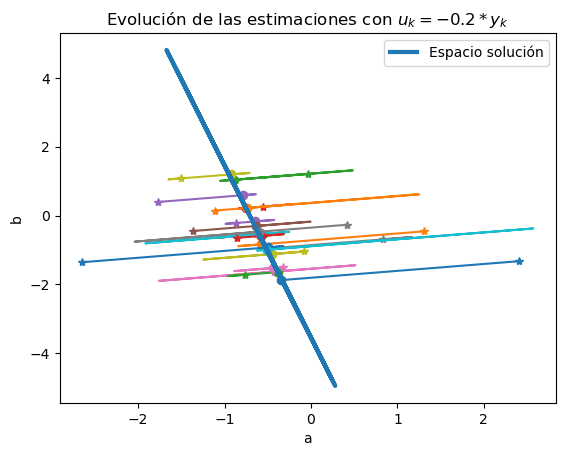

In [130]:
N = 1000
t = np.arange(N)

sigma_e = 0.5
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(20):
    color = colors[i % len(colors)]
    e = sigma_e*np.random.randn(N)

    y1 = np.zeros_like(e)
    u1 = np.zeros_like(e)
    for k in range(1, N):  
        y1[k] = -a*y1[k-1] + b*u1[k-1] + e[k] 
        u1[k] = -0.2*y1[k] 

    theta_ini = np.random.randn(2)
    theta_hat,P = estimador_RLS(u1,y1,theta_ini=theta_ini,lambda_=1,na=1,nb=1, plot=False)
    plt.plot(theta_hat[:,0],theta_hat[:,1],'-',color=color)
    plt.plot(theta_hat[0,0],theta_hat[0,1],'*',color=color)
    plt.plot(theta_hat[-1,0],theta_hat[-1,1],'o',color=color)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Evolución de las estimaciones con $u_k = -0.2*y_k$')



# Reconstruyo la matriz de covarianza
phi = np.array([y1[0:-2],u1[0:-2]]).T

# Compruebo que está mal condicionada
P_calc_inv = phi @ phi.T 
print(f"Determinante de la matriz de covarianza P={np.linalg.det(P_calc_inv)}")

# Calculo el espacio de soluciones
phi_mas = np.linalg.pinv(phi)
t_par = np.linspace(-5,5,100)
i = 0
theta = np.zeros((len(t_par),2))
for t in t_par:
    # El espacio solución sale de la solución general para el sistema de ecuaciones
    # Es decir una solución particular de norma mínima dada por la pseudoinversa
    # sumada la solución homogénea que está modulada por un vector parámetro que puede ser cualquier cosa
    # porque de todas formas el resultado termina en algún lugar del espacio solución
    theta[i,:] = phi_mas @ y1[1:-1] + (np.eye(2)-phi_mas@phi) @ np.random.rand(2)*t
    i+=1
plt.plot(-theta[:,0], theta[:,1],linewidth=3,label='Espacio solución')
plt.legend()


#v = Vt[0,:]  # Vector dirección
#print(v)
#alpha = np.linspace(-2, 2, 100)  # Escala para la recta
#x = alpha * v[1]
#y = alpha * v[0]
#plt.plot(x, y, label='Dirección U[:,0]')


Text(0.5, 1.0, 'Evolución de las estimaciones con $u_k = -0.32*y_{k-1}$')

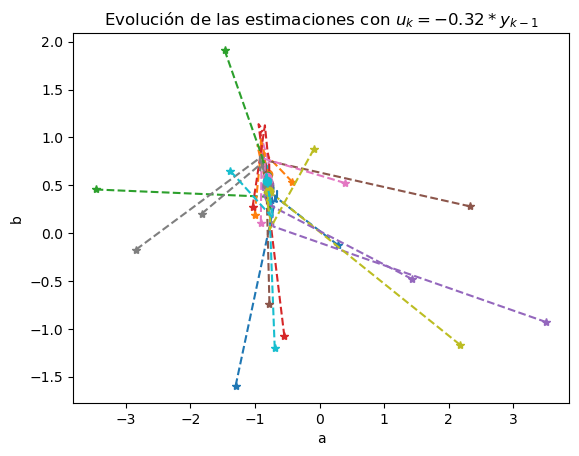

In [131]:
N = 3000
t = np.arange(N)

sigma_e = 0.5
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for i in range(20):
    color = colors[i % len(colors)]
    e = sigma_e*np.random.randn(N)

    y2 = np.zeros_like(e)
    u2 = np.zeros_like(e)
    for k in range(1, N):  
        y2[k] = -a*y2[k-1] + b*u2[k-1] + e[k] 
        u2[k] = -0.32*y2[k-1] 

    theta_ini = np.random.randn(2)
    NN=100
    theta_hat,P = estimador_RLS(u2,y2,theta_ini=theta_ini,lambda_=1,na=1,nb=1, plot=False)
    plt.plot(theta_hat[::NN,0],theta_hat[::NN,1],'--',color=color,label=f"Iter={i}")
    plt.plot(theta_hat[0,0],theta_hat[0,1],'*',color=color)
    plt.plot(theta_hat[-1,0],theta_hat[-1,1],'o',color=color)
plt.xlabel('a')
plt.ylabel('b')
plt.title('Evolución de las estimaciones con $u_k = -0.32*y_{k-1}$')
#plt.xlim(a*0.8,a*1.2)
#plt.ylim(b*0.8,b*1.2)


# Análisis del poder de excitación de las señales

Se analizan distintas señales de entrada y se evalúa su grado de persistencia excitatoria:
- En el dominio temporal: verificando la positividad de la matriz de autocorrelación (Toeplitz).
- En el dominio frecuencial: verificando la cantidad de frecuencias donde el espectro de potencia tiene energía significativa.




Testeo excitante: Escalón
Orden 1: Autovalor más pequeño: 1.000000
Orden 2: Autovalor más pequeño: 0.000100
Orden 3: Autovalor más pequeño: 0.000067
Orden 4: Autovalor más pequeño: 0.000059
Orden 5: Autovalor más pequeño: 0.000055


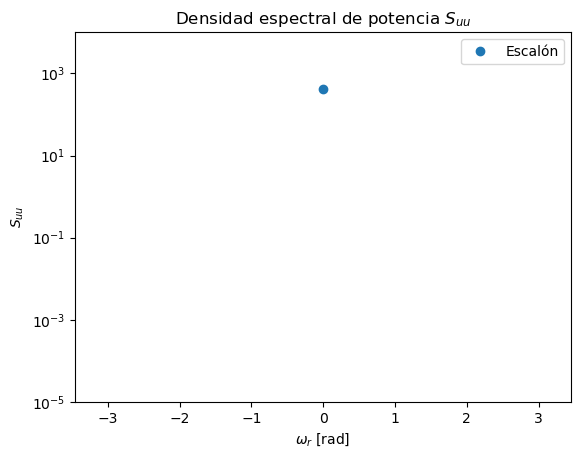



Testeo excitante: Delta
Orden 1: Autovalor más pequeño: 0.000100
Orden 2: Autovalor más pequeño: 0.000100
Orden 3: Autovalor más pequeño: 0.000100
Orden 4: Autovalor más pequeño: 0.000100
Orden 5: Autovalor más pequeño: 0.000100


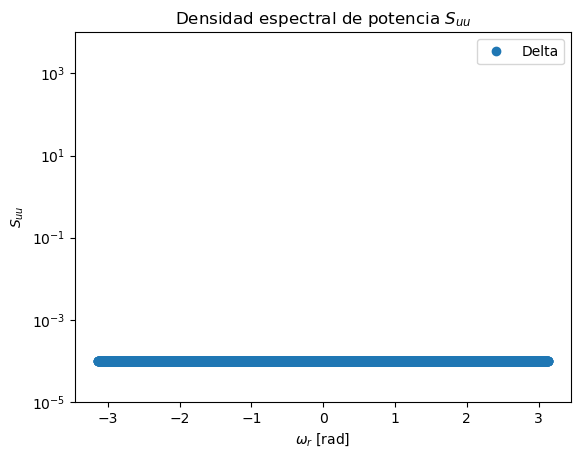



Testeo excitante: Senoidal
Orden 1: Autovalor más pequeño: 0.500000
Orden 2: Autovalor más pequeño: 0.095492
Orden 3: Autovalor más pequeño: 0.000015
Orden 4: Autovalor más pequeño: 0.000009
Orden 5: Autovalor más pequeño: 0.000007


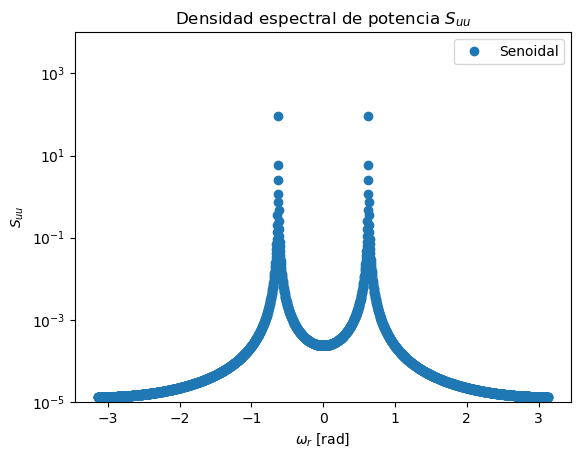



Testeo excitante: Aleatoria periodo N_per
Orden 1: Autovalor más pequeño: 1.409837
Orden 2: Autovalor más pequeño: 0.468740
Orden 3: Autovalor más pequeño: 0.468677
Orden 4: Autovalor más pequeño: 0.000423
Orden 5: Autovalor más pequeño: 0.000313


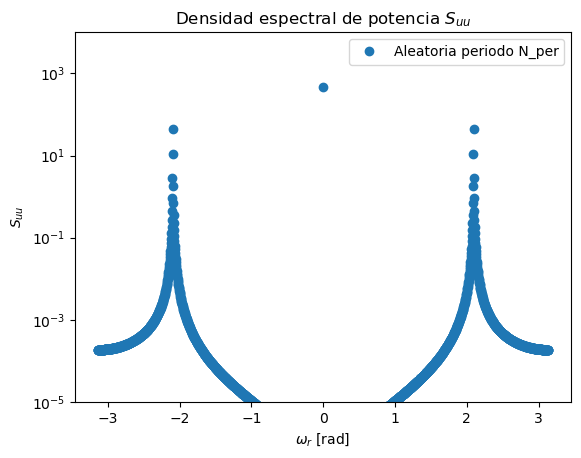



Testeo excitante: Aleatoria
Orden 1: Autovalor más pequeño: 1.000000
Orden 2: Autovalor más pequeño: 0.988900
Orden 3: Autovalor más pequeño: 0.986175
Orden 4: Autovalor más pequeño: 0.981735
Orden 5: Autovalor más pequeño: 0.979211


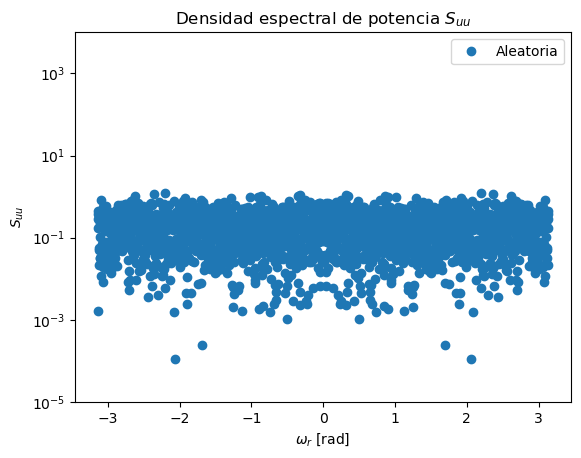

In [ ]:
# Consideremos un sistema MA de orden n: es un sistema FIR de orden n
# Vamos a testear distintas señales de entrada y ver su poder de excitación

N = 10000
tests = ['Escalón', 'Delta', 'Senoidal', 'Aleatoria periodo N_per', 'Aleatoria']
np.random.seed(0) # para reproducibilidad

for test in tests:
    print(f"\n\nTesteo excitante: {test}")
    if test=='Escalón':
        u = np.ones(N,)
    elif test=='Delta':
        u = np.zeros(N,)
        u[0] = 1
    elif test=='Senoidal':
        f0 = 0.1   # frecuencia normalizada (ciclos/muestra, entre 0 y 0.5)
        u = np.sin(2*np.pi*f0*np.arange(N))
    elif test=='Aleatoria periodo N_per':
        N_per = 3
        u = np.random.randn(N_per)
        u = np.tile(u, N//N_per)
    elif test=='Aleatoria':
        u = np.sign(np.random.randn(N))


    ruu = np.correlate(u,u,'full')/N
    ruu = ruu[ruu.size//2:] 

    for n in range(1,6):
        Cn = sc.linalg.toeplitz(ruu[:n])
        eigvals = sc.linalg.eigvals(Cn)
        print(f"Orden {n}: Autovalor más pequeño: {np.real(eigvals.min()):.6f}")

    U = np.fft.fft(u, n=2048)
    S_uu = np.abs(U)**2 / N
    omega = np.fft.fftfreq(len(S_uu), 1)*2*np.pi
    plt.figure()
    plt.semilogy(omega, S_uu, 'o', label=test)
    plt.ylim([1e-5, 1e4])
    plt.legend()
    plt.title("Densidad espectral de potencia $S_{{uu}}$")
    plt.xlabel('$\\omega_r$ [rad]')
    plt.ylabel('$S_{uu}$')
    plt.show()
